In [528]:
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import deeppavlov
from deeppavlov.dataset_readers.ontonotes_reader import OntonotesReader
from deeppavlov.models.preprocessors.capitalization import CapitalizationPreprocessor
from deeppavlov.models.embedders.glove_embedder import GloVeEmbedder

### Utility functions

In [529]:
def getNeTagMainPart(tag:str):
    return tag[2:] if tag != 'O' else tag

def tags2binary(tags, symb=True, types:list=None):
    tags = copy.deepcopy(tags)
    for seq in tags:
        for i in range(len(seq)):
            ne = False
            if seq[i] != 'O':
                ne = True
            if types and (getNeTagMainPart(seq[i]) not in types):
                ne = False
            if symb:
                seq[i] = 'T' if ne else 'O'
            else:
                seq[i] = 1 if ne else 0
#     print(np.sum(np.array([1 if t == 1 else 0 for seq in tags for t in seq])))
    return tags

def to_lower_case(tokens:list):
    tokens_lower = []
    for seq in tokens:
        tokens_lower.append([])
        for token in seq:
            tokens_lower[-1].append(token.lower())
    return tokens_lower

def get_tokens_len(tokens):
    if isinstance(tokens[0], str):
        tokens = [tokens]
    return [len(seq) for seq in tokens]

def add_padding(tokens:list):
    if isinstance(tokens[0], str):
        return tokens, len(tokens)
    elif isinstance(tokens[0], list):
        tokens = copy.deepcopy(tokens)
        max_len = 0
        for seq in tokens:
            if len(seq) > max_len:
                max_len = len(seq)
        for seq in tokens:
            i = len(seq)
            while i < max_len:
                seq.append('')
                i += 1
        return tokens
    else:
        raise Exception('tokens should be either list of strings or list of lists of strings')
        
def flatten_list(ar:list):
    flat = []
    for sublist in ar:
        flat += sublist
    return flat

def select_list_elements(ar:list, indices:list):
    return [ar[i] for i in indices]

### Read data

In [530]:
reader = OntonotesReader()
dataset = reader.read(data_path='data/')
print(dataset.keys())
print('Num of train sentences: {}'.format(len(dataset['train'])))
print('Num of valid sentences: {}'.format(len(dataset['valid'])))
print('Num of test sentences: {}'.format(len(dataset['test'])))
print(dataset['train'][50:60])

dict_keys(['train', 'valid', 'test'])
Num of train sentences: 75187
Num of valid sentences: 9603
Num of test sentences: 9479
[(['Actions', 'had', 'to', 'be', 'taken', 'to', 'break', 'through', 'the', 'blockade', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'a', 'night', 'in', 'late', 'July', '1940', ',', 'the', 'atmosphere', 'in', 'Zhuanbi', 'Village', 'in', 'Shaanxi', 'was', 'unusual', '.'], ['O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'B-GPE', 'I-GPE', 'O', 'B-GPE', 'O', 'O', 'O']), (['Villager', 'Xiao', 'Jianghe', 'has', 'a', 'vivid', 'memory', 'of', 'this', 'piece', 'of', 'history', '.'], ['O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'that', 'dark', 'night', ',', 'everyone', 'was', 'sleeping', 'when', 'human', 'voices', 'and', 'neighing', 'horses', 'were', 'heard', 'within', 'the', 'village', '.'], ['O', 'B-TIME', 'I-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

### Select sentences with chosen NE types only

In [531]:
def filter_data_by_ne_type(data:list, ne_types:list, tags2binary=False):
    if ne_types == None or len(ne_types) == 0:
        return data
    data_filtered = []
    for tokens,tags in data:
        contains_all = True
        tags_norm = [getNeTagMainPart(t) for t in tags]
        for ne_type in ne_types:
            if not ne_type in tags_norm:
                contains_all = False
                break
        if contains_all:
            if tags2binary:
                tags = ['T' if t in ne_types else 'O' for t in tags_norm]
            data_filtered.append((tokens,tags))
    return data_filtered

In [532]:
NE_TYPES = ['PERSON']
# NE_TYPES = ['GPE']
for dataset_type in ['train', 'valid', 'test']:
    dataset[dataset_type] = filter_data_by_ne_type(dataset[dataset_type], NE_TYPES, tags2binary=True)
    print('Num of {} sentences: {}'.format(dataset_type, len(dataset[dataset_type])))

Num of train sentences: 12195
Num of valid sentences: 1553
Num of test sentences: 1573


### Select few examples as support set

In [533]:
n_examples = 5
# np.random.seed(12)
indices = np.random.choice(len(dataset['train']), size=n_examples)
examples = [dataset['train'][i] for i in indices]
print(examples)

[(['NBC', 'News', 'has', 'produced', 'three', 'episodes', 'of', 'an', 'occasional', 'series', 'produced', 'by', 'Sid', 'Feders', 'called', '``', 'Yesterday', ',', 'Today', 'and', 'Tomorrow', ',', "''", 'starring', 'Maria', 'Shriver', ',', 'Chuck', 'Scarborough', 'and', 'Mary', 'Alice', 'Williams', ',', 'that', 'also', 'gives', 'work', 'to', 'actors', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'T', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'T', 'T', 'O', 'T', 'T', 'O', 'T', 'T', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['Mr.', 'Jath', 'is', 'thinking', 'of', 'passing', 'up', 'psyllium', 'altogether', 'this', 'year', 'in', 'favor', 'of', 'a', 'crop', 'with', 'a', 'future', 'such', 'as', 'cumin', 'or', 'fennel', '.'], ['O', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['It', 'was', 'former', 'Singapore', 'premier', 'Lee', 'Kuan', 'Yew', 'who', 'first', 'raised', 'the',

### Split tokens and tags

In [534]:
def split_tokens_tags(dataset: list):
    tokens = []
    tags = []
    for sample in dataset:
        tokens.append(sample[0])
        tags.append(sample[1])
    return tokens, tags

In [535]:
tokens_train,tags_train = split_tokens_tags(examples)
# print(tags_train)

In [536]:
def calc_data_props(tokens:list, tags:list):
    props = {}
    props['ne_types'] = {}
    tokens_flat = flatten_list(tokens)
    tags_flat = flatten_list(tags)
    ne_count = 0
    for tag in tags_flat:
        if tag != 'O':
            ne_count += 1
            tag_main = tag[2:]
            if props['ne_types'].get(tag_main) != None:
                props['ne_types'][tag_main] += 1
            else:
                props['ne_types'][tag_main] = 1
    props['sent_count'] = len(tokens)            
    props['tokens_count'] = len(tokens_flat)
    props['ne_count'] = ne_count
    props['ne_ratio'] = props['ne_count']/props['tokens_count']
    for k in props['ne_types'].keys():   
        props['ne_types'][k] /= ne_count
        
    return props
        
def print_data_props(props:dict):
    s = ''
    s += '#sentences = {}, '.format(props['sent_count'])
    s += '#tokens = {}, '.format(props['tokens_count'])
    s += '#ne = {}, '.format(props['ne_count'])
    s += '#ne / #tokens = {:.3f}, '.format(props['ne_ratio'])
    print(s)

In [537]:
print_data_props(calc_data_props(tokens_train,tags_train))

#sentences = 5, #tokens = 157, #ne = 20, #ne / #tokens = 0.127, 


### Elmo wrapper class

In [538]:
class ElmoEmbedder():
    def __init__(self):
        self.elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        self.sess = sess

    def get_tokens_embeddings(self, tokens_input: list, tokens_length:list=None):
        if not tokens_length:
            if isinstance(tokens_input[0], list):
                tokens_length = [len(seq) for seq in tokens_input]
            else:
                tokens_length = len(tokens_input)
        embeddings = self.elmo(
                        inputs={
                            "tokens": tokens_input,
                            "sequence_len": tokens_length
                        },
                        signature="tokens",
                        as_dict=True)["elmo"]
        embeddings = self.sess.run([embeddings])
        return embeddings[0]

### Main embedder

In [539]:
class CompositeEmbedder():
    def __init__(self, use_elmo=True, elmo_scale=1., cap_scale=1., use_cap_feat=False, use_glove=False, ):
        self.use_elmo = use_elmo
        self.elmo_scale = elmo_scale
        self.cap_scale = cap_scale
        self.use_cap_feat = use_cap_feat
        self.use_glove = use_glove
        if self.use_elmo:
            self.elmo = ElmoEmbedder()
        if self.use_cap_feat:
            self.cap_prep = CapitalizationPreprocessor()
        if self.use_glove:
            self.glove = GloVeEmbedder('embeddings/glove.6B/glove.6B.100d.txt', pad_zero=True)
        
    def embed(self, tokens: list):
        if isinstance(tokens[0], str):
            tokens = [tokens]
        # Get ELMo embeddings
        if self.use_elmo:
            tokens_input = add_padding(tokens)
            tokens_length = get_tokens_len(tokens)
            embeddings = self.elmo.get_tokens_embeddings(tokens_input, tokens_length)
            embeddings *= self.elmo_scale
            embed_size = embeddings.shape[-1]
#             print(embeddings.shape)
#             print(embed_size)

        # Use capitalization features
        if self.use_cap_feat:
#             print('Use capitalization features')
            cap_features = self.cap_prep(tokens)*self.cap_scale
    #         print(cap_features)
#             print(cap_features.shape)
            embeddings = np.concatenate((embeddings, cap_features), axis=2)
            embed_size = embeddings.shape[-1]
#             print(embeddings.shape)

        # Use GloVe embeddings
        if self.use_glove:
#             print('Use GloVe')
            
            glove_embed = self.glove(to_lower_case(tokens))
            glove_embed = np.array(glove_embed)
            if not self.use_elmo:
                embeddings = glove_embed
            else: 
                embeddings = np.concatenate((embeddings, glove_embed), axis=2)
            embed_size = embeddings.shape[-1]
#             print(embeddings.shape)
        
        return embeddings

### Calculate similarity of token embedding vector to some prototype (centroid) or just support vector

In [540]:
def calc_sim(token_vec, support_vec)->dict:
    sim = {}
    sim['euc_dist'] = np.exp(-np.linalg.norm(token_vec - support_vec))
    sim['dot_prod'] = np.dot(token_vec, support_vec)
    sim['cosine'] = np.dot(token_vec, support_vec)/(np.linalg.norm(token_vec)*np.linalg.norm(support_vec)) if np.linalg.norm(support_vec) != 0 else 0
    return sim

In [541]:
def calc_sim_batch(tokens: list, embeddings: np.ndarray, support_vec: np.ndarray)->list:
    sim_list = []
    tokens_length = get_tokens_len(tokens)
    for i in range(len(tokens_length)):
        sim_list.append([])
        for j in range(tokens_length[i]):
            token_vec = embeddings[i,j,:]
            sim_list[i].append(calc_sim(token_vec, support_vec))
    return sim_list

In [542]:
def flatten_sim(sim_list):
    sims_flat = {'euc_dist': [], 'dot_prod': [], 'cosine': []}
    for i in range(len(sim_list)):
        for j in range(len(sim_list[i])):
            for sim_type in ['euc_dist', 'dot_prod', 'cosine']:
                sims_flat[sim_type].append(sim_list[i][j][sim_type])
    for sim_type in ['euc_dist', 'dot_prod', 'cosine']:
        sims_flat[sim_type] = np.array(sims_flat[sim_type])
    return sims_flat

### Calculate centroid for named entities embedding vectors

In [543]:
def calc_ne_centroid_vec(tokens: list, tags: list, embeddings: np.ndarray=None, embedder: CompositeEmbedder=None):

    # Calculate embeddings
    if embedder != None:
        embeddings = embedder.embed(tokens)

    # Calculate average vector for ne-tags
    embed_size = embeddings.shape[-1]
    ne_prototype = np.zeros((embed_size,))
    tokens_length = get_tokens_len(tokens)
    tags_bin = np.array(flatten_list(tags2binary(tags, symb=False)))
#     print(tags_bin)
    n_ne_tags = np.sum(tags_bin == 1)
    embeddings_ne_flat = np.zeros((n_ne_tags, embed_size))
#     print(n_ne_tags)
#     n_ne_tags = 0
    k = 0
    for i in range(len(tokens_length)):
        for j in range(tokens_length[i]):
            if tags[i][j] == 'T' or tags[i][j] == 1:
                ne_prototype += embeddings[i,j,:].reshape((embed_size,))
                embeddings_ne_flat[k,:] = embeddings[i,j,:]
                k += 1
#                 n_ne_tags += 1
    if n_ne_tags != 0:
        ne_prototype /= n_ne_tags
    print('ne mean vector: {}'.format(ne_prototype))
    
    # Calculate similarities
    sim_list = calc_sim_batch(tokens, embeddings, ne_prototype)

    return ne_prototype, sim_list, embeddings, embeddings_ne_flat

### Calculate similarities of some test tokens to NE prototype

In [544]:
def calc_sim_to_ne_prototype(tokens: list, ne_prototype: np.ndarray, embeddings: np.ndarray=None, embedder: CompositeEmbedder=None):
    if isinstance(tokens[0], str):
        tokens = [tokens]
    
    tokens_length = get_tokens_len(tokens)
    
    # Calculate embeddings
    if embedder != None:
        embeddings = embedder.embed(tokens)
    
    # Calculate similarities
    sim_list = calc_sim_batch(tokens, embeddings, ne_prototype)
    
    return sim_list, embeddings

In [545]:
def calc_sim_to_ne_nearest(tokens: list, ne_support_embeddings: np.ndarray, embeddings: np.ndarray=None, embedder: CompositeEmbedder=None):
    if isinstance(tokens[0], str):
        tokens = [tokens]
    
    tokens_length = get_tokens_len(tokens)
    
    # Calculate embeddings
    if embedder != None:
        embeddings = embedder.embed(tokens)
    
    # Calculate similarities
    n_supports = ne_support_embeddings.shape[0]
    sim_list = []
    tokens_length = get_tokens_len(tokens)
    for i in range(len(tokens_length)):
        sim_list.append([])
        for j in range(tokens_length[i]):
            token_vec = embeddings[i,j,:]
            sim_token_list = {'euc_dist': [], 'dot_prod': [], 'cosine': []}
            for k in range(n_supports):
                sim = calc_sim(token_vec, ne_support_embeddings[k, :])
                for sim_type in ['euc_dist', 'dot_prod', 'cosine']:
                    sim_token_list[sim_type].append(sim[sim_type])
            sim_list[i].append({'euc_dist': np.min(np.array(sim_token_list['euc_dist'])), 
                                'dot_prod': np.max(np.array(sim_token_list['dot_prod'])), 
                                'cosine': np.max(np.array(sim_token_list['cosine']))})
            
    return sim_list, embeddings
    

### Embedder initialization

In [546]:
embedder = CompositeEmbedder(use_elmo=True, elmo_scale=1, cap_scale=1, use_cap_feat=True, use_glove=True)

INFO:tensorflow:Initialize variable module_5/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling


2018-08-13 15:40:48.879 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling


INFO:tensorflow:Initialize variable module_5/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights


2018-08-13 15:40:48.885 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights


INFO:tensorflow:Initialize variable module_5/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0


2018-08-13 15:40:48.892 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0


INFO:tensorflow:Initialize variable module_5/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_1


2018-08-13 15:40:48.897 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_1


INFO:tensorflow:Initialize variable module_5/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_2


2018-08-13 15:40:48.903 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_2


INFO:tensorflow:Initialize variable module_5/bilm/CNN/W_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_3


2018-08-13 15:40:48.909 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN/W_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_3


INFO:tensorflow:Initialize variable module_5/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4


2018-08-13 15:40:48.917 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4


INFO:tensorflow:Initialize variable module_5/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5


2018-08-13 15:40:48.924 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5


INFO:tensorflow:Initialize variable module_5/bilm/CNN/W_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_6


2018-08-13 15:40:48.931 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN/W_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_6


INFO:tensorflow:Initialize variable module_5/bilm/CNN/b_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_0


2018-08-13 15:40:48.938 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN/b_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_0


INFO:tensorflow:Initialize variable module_5/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1


2018-08-13 15:40:48.947 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1


INFO:tensorflow:Initialize variable module_5/bilm/CNN/b_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_2


2018-08-13 15:40:48.952 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN/b_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_2


INFO:tensorflow:Initialize variable module_5/bilm/CNN/b_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_3


2018-08-13 15:40:48.959 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN/b_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_3


INFO:tensorflow:Initialize variable module_5/bilm/CNN/b_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_4


2018-08-13 15:40:48.965 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN/b_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_4


INFO:tensorflow:Initialize variable module_5/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5


2018-08-13 15:40:48.975 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5


INFO:tensorflow:Initialize variable module_5/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6


2018-08-13 15:40:48.982 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6


INFO:tensorflow:Initialize variable module_5/bilm/CNN_high_0/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_carry


2018-08-13 15:40:48.990 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN_high_0/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_carry


INFO:tensorflow:Initialize variable module_5/bilm/CNN_high_0/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_transform


2018-08-13 15:40:48.997 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN_high_0/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_transform


INFO:tensorflow:Initialize variable module_5/bilm/CNN_high_0/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_carry


2018-08-13 15:40:49.2 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN_high_0/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_carry


INFO:tensorflow:Initialize variable module_5/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_transform


2018-08-13 15:40:49.9 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_transform


INFO:tensorflow:Initialize variable module_5/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry


2018-08-13 15:40:49.15 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry


INFO:tensorflow:Initialize variable module_5/bilm/CNN_high_1/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_transform


2018-08-13 15:40:49.23 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN_high_1/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_transform


INFO:tensorflow:Initialize variable module_5/bilm/CNN_high_1/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_carry


2018-08-13 15:40:49.31 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN_high_1/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_carry


INFO:tensorflow:Initialize variable module_5/bilm/CNN_high_1/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_transform


2018-08-13 15:40:49.38 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN_high_1/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_transform


INFO:tensorflow:Initialize variable module_5/bilm/CNN_proj/W_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/W_proj


2018-08-13 15:40:49.45 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN_proj/W_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/W_proj


INFO:tensorflow:Initialize variable module_5/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj


2018-08-13 15:40:49.52 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj


INFO:tensorflow:Initialize variable module_5/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


2018-08-13 15:40:49.59 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_5/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


2018-08-13 15:40:49.67 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_5/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


2018-08-13 15:40:49.75 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_5/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


2018-08-13 15:40:49.81 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_5/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


2018-08-13 15:40:49.89 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_5/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


2018-08-13 15:40:49.94 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_5/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


2018-08-13 15:40:49.101 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_5/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


2018-08-13 15:40:49.109 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_5/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


2018-08-13 15:40:49.115 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_5/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


2018-08-13 15:40:49.122 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_5/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


2018-08-13 15:40:49.129 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_5/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


2018-08-13 15:40:49.135 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_5/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed


2018-08-13 15:40:49.140 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_5/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed
2018-08-13 15:40:50.846 INFO in 'deeppavlov.models.embedders.glove_embedder'['glove_embedder'] at line 60: [loading embeddings from `/home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt`]
2018-08-13 15:40:50.847 INFO in 'gensim.models.keyedvectors'['keyedvectors'] at line 204: loading projection weights from /home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt
2018-08-13 15:40:50.847 DEBUG in 'smart_open.smart_open_lib'['smart_open_lib'] at line 176: {'kw': {}, 'mode': 'rb', 'uri': '/home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt'}
2018-08-13 15:41:20.782 INFO in 'gensim.models.keyedvectors'['keyedvectors'] at line 266: loaded (400000, 100) ma

### Calculate NE centroid for support examples

In [547]:
ne_prototype, _, embeddings_support, ne_support_embeddings = calc_ne_centroid_vec(tokens_train, tags_train, embedder=embedder)
print(ne_support_embeddings.shape)

ne mean vector: [-0.00614684 -0.17078662  0.07800366 ... -0.72381988  0.0574335
 -0.2038887 ]
(20, 1128)


### Select some unlabeled examples from the test set and estimate similarity to a named entity for each token

In [548]:
n_test_sentences = 100
# np.random.seed(44)
indices_test = np.random.choice(len(dataset['test']), size=n_test_sentences)
test_sentences = select_list_elements(dataset['test'], indices_test)
tokens_test,tags_test = split_tokens_tags(test_sentences)
print_data_props(calc_data_props(tokens_test,tags_test))
# print(tokens_test)
# print(tags_test)

#sentences = 100, #tokens = 2418, #ne = 216, #ne / #tokens = 0.089, 


In [549]:
sim_list_test = {}
sim_list_test['centroid'], embeddings_test = calc_sim_to_ne_prototype(tokens_test, ne_prototype, embedder=embedder)
sim_list_test['nearest'], _ = calc_sim_to_ne_nearest(tokens_test, ne_support_embeddings, embedder=embedder)

### Group similarities with tokens

In [550]:
def zip_tokens_sim(tokens: list, sim_list: list, sim_type='cosine'):
    tokens_sim = []
    for i in range(len(tokens)):
        tokens_sim.append([])
        for j in range(len(tokens[i])):
            sim = sim_list[i][j][sim_type] if isinstance(sim_list[i][j], dict) else sim_list[i][j]
            tokens_sim[-1].append((tokens[i][j], sim))
    return tokens_sim

In [551]:
tokens_test_sim = {}
tokens_test_sim['centroid'] = zip_tokens_sim(tokens_test, sim_list_test['centroid'])
tokens_test_sim['nearest'] = zip_tokens_sim(tokens_test, sim_list_test['nearest'])

### Print test sentences with NE similarities estimations

In [552]:
def decorate_ne_token(token, tag):
    if tag == 'T':
        token = '[[' + token + ']]'
    return token
def format_labeled_examples(tokens_input: list, tags_input: list):
    s = '+++++++++ Input examples +++++++++\n\n'
    for i in range(len(tokens_input)):
        for j in range(len(tokens_input[i])):
            s += decorate_ne_token(tokens_input[i][j], tags_input[i][j]) + ' '
        s += '\n\n'
    return s

In [553]:
def format_inference_results(tokens_sim: list):
    s = '+++++++++ Tests +++++++++\n\n'
    for seq in tokens_sim:
        for token, sim in seq:
            s += '{}[{:.3f}]'.format(token, sim)
            s += ' '
        s += '\n\n'
    return s

In [554]:
text = ''
text += format_labeled_examples(tokens_train, tags_train)
text += format_inference_results(tokens_test_sim['centroid'])
print(text)

+++++++++ Input examples +++++++++

NBC News has produced three episodes of an occasional series produced by [[Sid]] [[Feders]] called `` Yesterday , Today and Tomorrow , '' starring [[Maria]] [[Shriver]] , [[Chuck]] [[Scarborough]] and [[Mary]] [[Alice]] [[Williams]] , that also gives work to actors . 

Mr. [[Jath]] is thinking of passing up psyllium altogether this year in favor of a crop with a future such as cumin or fennel . 

It was former Singapore premier [[Lee]] [[Kuan]] [[Yew]] who first raised the banner of " Asian Values . " 

Prince [[Al]] [[-]] [[Waleed]] confirmed that the Kingdom Holding Company is continuing with its plans to list for sale a percentage of its shares agreed upon with the state , to reach a figure that serves the Saudi citizen and does not harm the future interests of the Company and its expansions . 

In [[Shuang]] [[-]] [[tzu]] [['s]] case , this reflects her experience as the administrator of a BBS site . 

+++++++++ Tests +++++++++

The[0.239] show[0

In [555]:
text = ''
text += format_labeled_examples(tokens_train, tags_train)
text += format_inference_results(tokens_test_sim['nearest'])
print(text)

+++++++++ Input examples +++++++++

NBC News has produced three episodes of an occasional series produced by [[Sid]] [[Feders]] called `` Yesterday , Today and Tomorrow , '' starring [[Maria]] [[Shriver]] , [[Chuck]] [[Scarborough]] and [[Mary]] [[Alice]] [[Williams]] , that also gives work to actors . 

Mr. [[Jath]] is thinking of passing up psyllium altogether this year in favor of a crop with a future such as cumin or fennel . 

It was former Singapore premier [[Lee]] [[Kuan]] [[Yew]] who first raised the banner of " Asian Values . " 

Prince [[Al]] [[-]] [[Waleed]] confirmed that the Kingdom Holding Company is continuing with its plans to list for sale a percentage of its shares agreed upon with the state , to reach a figure that serves the Saudi citizen and does not harm the future interests of the Company and its expansions . 

In [[Shuang]] [[-]] [[tzu]] [['s]] case , this reflects her experience as the administrator of a BBS site . 

+++++++++ Tests +++++++++

The[0.333] show[0

### Visualize similarities of tokens to NE

In [556]:
from IPython.core.display import display, HTML

In [557]:
def get_color(red=0, green=255, blue=0):
    return {'r': red, 'g': green, 'b': blue}

def get_rgba_str(color, alpha=1):
    return 'rgba({},{},{},{})'.format(color['r'], color['g'], color['b'], alpha)

def get_token_span_str(token, color, cf=1):
    return '<span style="padding: 0.15em; margin-right: 4px; border-radius: 0.25em; background: {};">{}</span>'.format(get_rgba_str(color, alpha=cf), token)

def wrap_with_style(html):
    return '<div style="line-height: 1.5em;">{:s}</div>'.format(html)

In [558]:
def calc_sim_min_max(sim_list):
    sim_flat = flatten_sim(sim_list)
    sim_min = np.min(sim_flat['cosine'])
    sim_max = np.max(sim_flat['cosine'])
    return (sim_min, sim_max)

In [559]:
def sim_transform_lin(sim, sim_min, sim_max):
    # similarity transformation for better visualization
    return (sim - sim_min)/(sim_max - sim_min)
def sim_transform(sim, sim_min, sim_max, T=0.5):
    # similarity transformation with temperature for better visualization
    return (np.exp(sim/T) - np.exp(sim_min/T))/(np.exp(sim_max/T) - np.exp(sim_min/T))

In [560]:
def get_colored_results_html(tokens_sim: list, sim_min_max:tuple, color, T=0.5, caption=None):
    if sim_min_max != None:
        sim_min, sim_max = sim_min_max
    if not caption:
        caption = 'Visualization of tokens to NE similarities on test set'
    s = '<h3 style="margin-bottom:0.3em;">{}</h3>'.format(caption)
    for seq in tokens_sim:
        ch = 0
        for token, sim in seq:
            if sim_min_max != None:
                sim = sim_transform(sim, sim_min, sim_max, T)
            s += get_token_span_str(token, color, cf=sim)
            ch += len(token)
            if ch > 100:
                s += '<br/>'
                ch = 0
#             s += ' '
        s += '<br/><br/>'
    return wrap_with_style(s)

In [561]:
tags_list_bin_train = tags2binary(tags_train, symb=False)
tokens_train_sim = zip_tokens_sim(tokens_train, tags_list_bin_train)
display(HTML(get_colored_results_html(tokens_train_sim, (0,1), color=get_color(244,50,244), caption='Support examples')))

In [562]:
bg_color = get_color()
display(HTML(get_colored_results_html(tokens_test_sim['centroid'][:10], calc_sim_min_max(sim_list_test['centroid'][:10]), bg_color)))

In [563]:
display(HTML(get_colored_results_html(tokens_test_sim['nearest'][:10], calc_sim_min_max(sim_list_test['nearest'][:10]), bg_color)))

### Plot histograms of test similarities

(2418,)
216
(2202,)
(216,)
(2202,)
(216,)


/home/kostrovskiy/prog/AI/NLP/DeepPavlov/env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


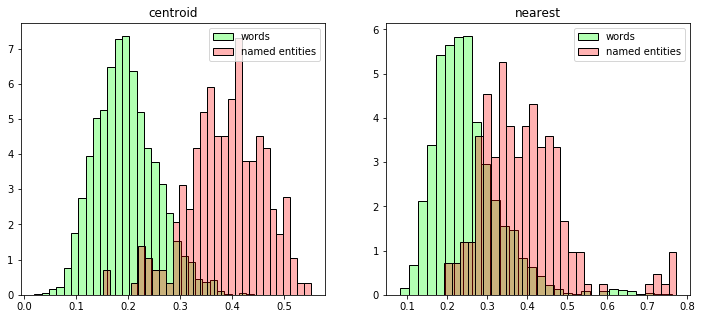

In [564]:
# tags_test_bin_flat = np.array(flatten_list(tags2binary(tags_test, symb=False))) # TODO: bag here
# print(np.sum(np.array([1 if t == 1 else 0 for seq in tags2binary(tags_test, symb=False) for t in seq])))
tags_test_bin_flat = np.array([1 if t == 'T' else 0 for seq in tags_test for t in seq])
# dif_tags = set()
# for seq in tags_test:
#     for t in seq:
#         dif_tags.add(t)
# print(dif_tags)
print(tags_test_bin_flat.shape)
print(np.sum(tags_test_bin_flat))
sim_test_words = {}
sim_test_ne = {}
plt.figure(figsize=(12,5))
for i, method in enumerate(['centroid', 'nearest']):
    sim_flat = np.array(flatten_sim(sim_list_test[method])['cosine'])
    sim_test_words[method] = sim_flat[tags_test_bin_flat == 0]
    sim_test_ne[method] = sim_flat[tags_test_bin_flat == 1]
    print(sim_test_words[method].shape)
    print(sim_test_ne[method].shape)
    plt.subplot(1, 2, i+1, title=method)
    plt.hist(sim_test_words[method], normed=True, color = 'green', edgecolor = 'black',
         bins = 30, label='words', fc=(0, 1, 0, 0.3))
    plt.hist(sim_test_ne[method], normed=True, color = 'red', edgecolor = 'black',
             bins = 30, label='named entities', fc=(1, 0, 0, 0.3))
    plt.legend()

### Plot probability densities

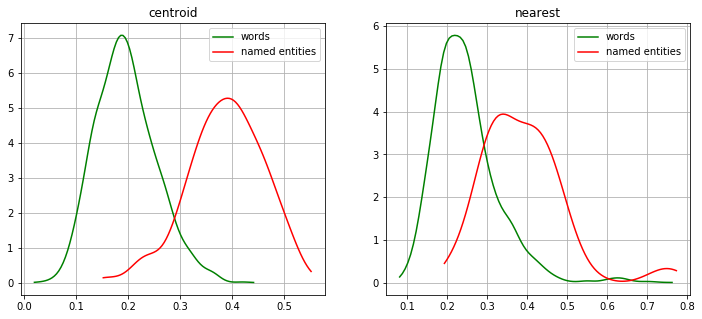

In [565]:
# https://stackoverflow.com/questions/15415455/plotting-probability-density-function-by-sample-with-matplotlib
from scipy.stats.kde import gaussian_kde
from numpy import linspace
plt.figure(figsize=(12,5))
for i, method in enumerate(['centroid', 'nearest']):
    kde_words = gaussian_kde( sim_test_words[method] )
    dist_space_words = linspace( min(sim_test_words[method]), max(sim_test_words[method]), 100 )
    kde_ne = gaussian_kde( sim_test_ne[method] )
    dist_space_ne = linspace( min(sim_test_ne[method]), max(sim_test_ne[method]), 100 )
    plt.subplot(1, 2, i+1, title=method)
    plt.plot( dist_space_words, kde_words(dist_space_words), color='green', label='words' )
    plt.plot( dist_space_ne, kde_ne(dist_space_ne), color='red',  label='named entities' )
    plt.legend(loc='upper right')
    plt.grid()
#     plt.title('Probability densities')

### F1 score

In [566]:
def infer_tags(sim_list, sim_type, T=0.5, threshold=0.5):
    sim_min, sim_max = calc_sim_min_max(sim_list)
    tokens_length = get_tokens_len(sim_list)
    tags = [['T' if sim_transform(sim_list[i][j][sim_type], sim_min, sim_max, T)  > threshold else 'O' for j in range(tokens_length[i])] for i in range(len(tokens_length))]
    return tags

In [597]:
from sklearn.metrics import f1_score
f1 = {}
for i, method in enumerate(['centroid', 'nearest']):
    sim_list = sim_list_test[method]  
    tags_test_pred = infer_tags(sim_list, 'cosine', T=1, threshold=0.5)
#     target = flatten_list(tags2binary(tags_test, symb=False))
#     pred = flatten_list(tags2binary(tags_test_pred, symb=False))
    target = [1 if t == 'T' else 0 for seq in tags_test for t in seq]
    pred = [1 if t == 'T' else 0 for seq in tags_test_pred for t in seq]
#     print(sum(target))
#     print(sum(pred))
    f1[method] = f1_score(target, pred)
print('F1 scores:')
for k in f1.keys():
    print('{}: {:3f}'.format(k, f1[k]))

F1 scores:
centroid: 0.793028
nearest: 0.183824


In [568]:
print('+++++ Samples stats +++++')
print('Support set:')
print_data_props(calc_data_props(tokens_train,tags_train))
print('Tests:')
print_data_props(calc_data_props(tokens_test,tags_test))

+++++ Samples stats +++++
Support set:
#sentences = 5, #tokens = 157, #ne = 20, #ne / #tokens = 0.127, 
Tests:
#sentences = 100, #tokens = 2418, #ne = 216, #ne / #tokens = 0.089, 


In [569]:
print(np.sum(np.array([1 if t == 'T' else 0 for seq in tags_test for t in seq])))

216


### Try SVM 

In [570]:
def get_tokens_count(tokens:list):
    return len([t for seq in tokens for t in seq])
def embeddings2feat_mat(embeddings:np.ndarray, tokens_length):
    n_tokens = sum(tokens_length)
    n_features = embeddings.shape[-1]
    feat_mat = np.zeros((n_tokens, n_features))
#     print(feat_mat.shape)
    k = 0
    for i in range(len(tokens_length)):
        for j in range(tokens_length[i]):
            feat_mat[k, :] = embeddings[i, j, :]
            k += 1           
    return feat_mat

In [587]:
from sklearn.svm import SVC
X_train = embeddings2feat_mat(embeddings_support, get_tokens_len(tokens_train))
y_train = np.array([1 if t == 'T' else 0 for seq in tags_train for t in seq])
# print(np.bincount(y_train))
n_ne = sum(y_train)
n_words = y_train.size - sum(y_train)
n_tokens = n_ne + n_words
weights = [n_tokens/(2*n_ne) if label == 1 else n_tokens/(2*n_words) for label in y_train]
print(n_ne)
print(n_words)
# print(np.unique(weights))
clf = SVC(probability=True, kernel='linear')
clf.fit(X_train, y_train, weights)
X_test = embeddings2feat_mat(embeddings_test, get_tokens_len(tokens_test))
y_test = np.array([1 if t == 'T' else 0 for seq in tags_test for t in seq])
pred = clf.predict(X_test)
print(sum(pred))
print(clf.score(X_test, y_test))
print('F1 score: {}'.format(f1_score(y_test, pred)))
# print(clf.decision_function(X_test))
# print(np.min(clf.decision_function(X_test)))
# print(np.max(clf.decision_function(X_test)))
sim_list = clf.predict_proba(X_test)[:,1]
print(np.max(sim_list))

20
137
180
0.9702233250620348
F1 score: 0.8181818181818182
0.995004860994317


In [572]:
def zip_tokens_sim_list(tokens, sim_list):
    tokens_sim = []
    k = 0
    print(len(sim_list.shape))
    for seq in tokens:
        tokens_sim.append([])
        for t in seq:
            tokens_sim[-1].append((t, sim_list[k]))
            k += 1
    return tokens_sim

In [573]:
display(HTML(get_colored_results_html(zip_tokens_sim_list(tokens_test, sim_list), None, bg_color, T=1)))

1


0.00744938879646677
0.9896730313471045
(2202,)
(216,)


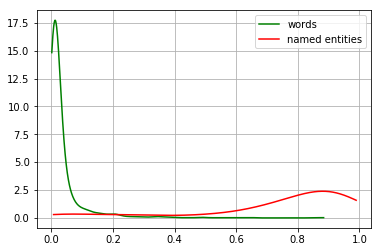

In [574]:
sim_words = sim_list[y_test == 0]
sim_ne = sim_list[y_test == 1]
print(np.min(sim_ne))
print(np.max(sim_ne))
print(sim_words.shape)
print(sim_ne.shape)
kde_words = gaussian_kde(sim_words)
dist_space_words = linspace( min(sim_words), max(sim_words), 1000 )
kde_ne = gaussian_kde(sim_ne)
dist_space_ne = linspace( min(sim_ne), max(sim_ne), 1000 )
plt.plot( dist_space_words, kde_words(dist_space_words), color='green', label='words' )
plt.plot( dist_space_ne, kde_ne(dist_space_ne), color='red',  label='named entities' )
plt.legend(loc='upper right')
plt.grid()

### Weighted kNN

In [575]:
import sys
from math import ceil, floor
def calc_weighted_kNN(X_train, y_train, X_test, y_test=None, k=1, metric='dot_prod', use_class_weights=True, use_sim_weights=True):
    # Weights for classes
    n_classes = np.unique(y_train).size
    n_train_samples = y_train.size
    class_weights = np.array([1,1])
    if use_class_weights:
        class_weights = n_train_samples/(n_classes*np.bincount(y_train))
#     print(np.bincount(y_train))
#     print(n_classes)
#     print(weights)
    n_test_samples = X_test.shape[0]
    probas = np.zeros((n_test_samples))
    pred = np.zeros((n_test_samples), dtype=np.int64)
    # Find k nearest neighbours for each test sample
    for idx_test in range(n_test_samples):
        x = X_test[idx_test,:]
        top_k_sim = np.zeros((k))
        top_k_sim.fill(np.NINF)
        top_k_labels = np.zeros((k), dtype=np.int64)
        for idx_train in range(n_train_samples):
            sim = calc_sim(x, X_train[idx_train, :])[metric]
            for i, sim_from_top in enumerate(top_k_sim):
                if sim > sim_from_top:
                    top_k_sim[i] = sim
                    top_k_labels[i] = y_train[idx_train]
                    break
#         print(top_k_sim)
#         print(top_k_labels)
        calc_prob_dist = lambda ar: ar/(np.sum(ar))
        n_labels_c1 = np.sum(top_k_labels.astype(np.int64))
        n_labels_c0 = top_k_labels.size - n_labels_c1
        if use_sim_weights:
            n_labels_c1 = top_k_sim[top_k_labels == 1].dot(np.ones((n_labels_c1)))
            n_labels_c0 = top_k_sim[top_k_labels == 0].dot(np.ones((n_labels_c0)))
        bincount = np.array([n_labels_c0, n_labels_c1])
#         print(bincount)
        prob_cur = calc_prob_dist(class_weights*bincount)
#         print(prob_cur)
        probas[idx_test] = prob_cur[1]
        pred[idx_test] = 1 if prob_cur[1] > prob_cur[0] else 0
#         print(pred[idx_test])
        # https://stackoverflow.com/questions/3002085/python-to-print-out-status-bar-and-percentage
        sys.stdout.write('\r')
        progress = idx_test/X_test.shape[0]
        sys.stdout.write("[%-20s] %d%%" % ('='*int(ceil(progress*20)), ceil(progress*100)))
        sys.stdout.flush()
#         print(prob_cur)
#     print(probas)
    return pred, probas

In [576]:
pred, probas = calc_weighted_kNN(X_train, y_train, X_test, y_test=None, k=3, metric='cosine', use_class_weights=False, use_sim_weights=True)


[====================] 100%

In [577]:
print('F1 score: {}'.format(f1_score(y_test, pred)))
print(np.sum(pred))

F1 score: 0.7762557077625571
222


In [578]:
display(HTML(get_colored_results_html(zip_tokens_sim_list(tokens_test, probas), None, bg_color, T=1)))

1


0.0
1.0
(2202,)
(216,)


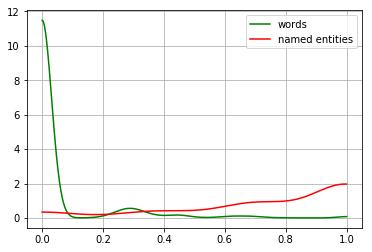

In [579]:
sim_words = probas[y_test == 0]
sim_ne = probas[y_test == 1]
print(np.min(sim_ne))
print(np.max(sim_ne))
print(sim_words.shape)
print(sim_ne.shape)
kde_words = gaussian_kde(sim_words)
dist_space_words = linspace( min(sim_words), max(sim_words), 1000 )
kde_ne = gaussian_kde(sim_ne)
dist_space_ne = linspace( min(sim_ne), max(sim_ne), 1000 )
plt.plot( dist_space_words, kde_words(dist_space_words), color='green', label='words' )
plt.plot( dist_space_ne, kde_ne(dist_space_ne), color='red',  label='named entities' )
plt.legend(loc='upper right')
plt.grid()

### Centroid for NE and kNN for words

In [580]:
def softmax(ar, scale=True):
    ar = ar[:]
    eps = 1e-10
    if scale:
        ar_min = np.min(ar)
        ar_max = np.max(ar)
        if abs(ar_max - ar_min) > eps:
            ar = (ar - ar_min)/(ar_max - ar_min)
    return np.exp(ar)/(np.sum(np.exp(ar)))

def calc_centroid_kNN(X_train, y_train, X_test, y_test=None, k=5, metric='cosine', use_class_weights=True):
    # Weights for classes
    n_classes = np.unique(y_train).size
    n_train_samples = y_train.size
    class_weights = np.array([1,1])
    if use_class_weights:
        class_weights = n_train_samples/(n_classes*np.bincount(y_train))

    # Centroid for class 1 examples
    centroid_c1 = np.mean(X_train[y_train == 1, :], axis=0)
#     print(centroid_c1.shape)
    
    n_test_samples = X_test.shape[0]
    probas = np.zeros((n_test_samples))
    pred = np.zeros((n_test_samples), dtype=np.int64)
    # Find k nearest neighbours of class 0 for each test sample
    for idx_test in range(n_test_samples):
        x = X_test[idx_test,:]
        sim_c1 = calc_sim(x, centroid_c1)[metric]
        top_k_sim = np.zeros((k))
        top_k_sim.fill(np.NINF)
        for _, example_c0 in enumerate(X_train[y_train == 0, :]):
            sim = calc_sim(x, example_c0)[metric]
            for i, sim_from_top in enumerate(top_k_sim):
                if sim > sim_from_top:
                    top_k_sim[i] = sim
                    break
#         print(top_k_sim)
#         print(top_k_labels)
        sim_c0 = np.mean(top_k_sim)
#         print(sim_c0)
#         print(sim_c1)
        prob_cur = softmax(class_weights*np.array([sim_c0, sim_c1]))
#         print(prob_cur)
        probas[idx_test] = prob_cur[1]
        pred[idx_test] = 1 if prob_cur[1] > prob_cur[0] else 0
#         print(pred[idx_test])
        # https://stackoverflow.com/questions/3002085/python-to-print-out-status-bar-and-percentage
        sys.stdout.write('\r')
        progress = idx_test/X_test.shape[0]
        sys.stdout.write("[%-20s] %d%%" % ('='*int(ceil(progress*20)), ceil(progress*100)))
        sys.stdout.flush()
#         print(prob_cur)
#     print(probas)
    return pred, probas

In [588]:
pred, probas = calc_centroid_kNN(X_train, y_train, X_test, y_test=None, k=10, metric='dot_prod', use_class_weights=False)

[====================] 100%

In [589]:
print('F1 score: {}'.format(f1_score(y_test, pred)))
print('#class 1 predictions = {}'.format(np.sum(pred)))

F1 score: 0.8557457212713937
#class 1 predictions = 193


In [583]:
display(HTML(get_colored_results_html(zip_tokens_sim_list(tokens_test, probas), None, bg_color, T=1)))

1


### Clear memory

In [584]:
# del embeddings_support
# del embeddings_test